# Transfer Learning (Fearture Extraction)


## Download pretrained data


In [ ]:
import zipfile
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

--2023-09-13 01:02:43--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.207, 2a00:1450:4013:c01::cf, 2a00:1450:4013:c07::cf, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  37.7MB/s    in 5.0s    

2023-09-13 01:02:48 (32.2 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



## Preperaing data with creating data loaders

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# path of our data
train_dir = '10_food_classes_10_percent/train/'
test_dir = '10_food_classes_10_percent/test/'

# Setup data gen
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Setup Hyperparams
IMG_SHAPE = (224, 224)
BATCH_SIZE = 32

# Load our data from directories
train_data_10_precent = train_datagen.flow_from_directory(train_dir,
                                                          target_size = IMG_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')

test_data_10_precent = train_datagen.flow_from_directory(test_dir,
                                                          target_size = IMG_SHAPE,
                                                          batch_size = BATCH_SIZE,
                                                          class_mode = 'categorical')

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


## Let's make Our Callback function for TensorBoard
**Why?** Because: To know time and tracking our creating models

In [ ]:
# Let's create tensorflow callback
import datetime
import tensorflow as tf

# create function
def create_tensorboard_callback(dir_name, exp_name):
  """That function crate callback of tensorboard for our models
  to know what time is model is created at it

  Args:
    dir_name : it 's the name of directory that we want to save our models in it
    exp_name : it 's name of model that will we pretrained on it from tensorflow hub

  return:
    tensorboard_callback : which is created directory with model
  """

  # create log_dir
  log_dir = dir_name + "/" + exp_name + "/" + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')

  # Create tensorborad callback
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

  # Priniting message
  print(f"Saving TensorBoard in {log_dir}")

  return tensorboard_callback

## Function to plot loss curves

In [ ]:
# Let's make function that take hist then plot validation and training curves
import matplotlib.pyplot as plt

def plot_loss_curve(hist):
  # For losses
  loss = hist.history['loss']
  val_loss = hist.history['val_loss']

  # For accuracy
  accuracy = hist.history['accuracy']
  val_accuracy = hist.history['val_accuracy']

  epochs = range(len(loss))

  # plot loss
  plt.figure()
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, val_loss, label='test_loss')
  plt.xlabel('epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='train_accuracy')
  plt.plot(epochs, val_accuracy, label='test_accuracy')
  plt.xlabel('epochs')
  plt.legend()

## Let's get our trained model from tensorflow hub

In [ ]:
# urls
resnet_v1_50_url   = 'https://tfhub.dev/google/imagenet/resnet_v1_50/feature_vector/5'
efficietnet_b0_url = 'https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1'

## Let's Create function that create model from pretrained urls of tensorflow hub

In [ ]:
# import dep
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential

# create function
def create_model(model_url, class_nums = 10):
  """That function create our pretrained model which take url and
  make it as layer which will be used later in Sequentioal

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """

  # Download pretrained model
  feature_extarctor_layer = hub.KerasLayer(model_url,
                                           trainable=False,
                                           name = 'feature_extarction_layer',
                                           input_shape = IMG_SHAPE + (3,))

  # Create our model
  model = Sequential([
      feature_extarctor_layer,
      Dense(class_nums, activation='softmax', name='out_layer')
  ])

  return model

## Let's create nad compile and fit our pretrained model (resnet model)

In [ ]:
# 1. craet model
resnet_model = create_model(model_url=resnet_v1_50_url,
                            class_nums = train_data_10_precent.num_classes)

# 2. compile model
resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

In [ ]:
# 3. fit our model
resnet_hist = resnet_model.fit(train_data_10_precent,
                               epochs = 5,
                               steps_per_epoch = len(train_data_10_precent),
                               validation_data = test_data_10_precent,
                               validation_steps = len(test_data_10_precent),
                               callbacks=[create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                      exp_name = 'resnet_v1_50')])

Saving TensorBoard in tensorflow_hub/resnet_v1_50/20230913-010309
Epoch 1/5
24/24 [==============================] - 30s 557ms/step - loss: 1.8111 - accuracy: 0.4040 - val_loss: 1.1393 - val_accuracy: 0.6480
Epoch 2/5
24/24 [==============================] - 12s 514ms/step - loss: 0.8521 - accuracy: 0.7427 - val_loss: 0.8317 - val_accuracy: 0.7444
Epoch 3/5
24/24 [==============================] - 11s 461ms/step - loss: 0.5835 - accuracy: 0.8280 - val_loss: 0.7585 - val_accuracy: 0.7684
Epoch 4/5
24/24 [==============================] - 13s 543ms/step - loss: 0.4261 - accuracy: 0.9013 - val_loss: 0.7012 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 10s 435ms/step - loss: 0.3328 - accuracy: 0.9333 - val_loss: 0.6704 - val_accuracy: 0.7896


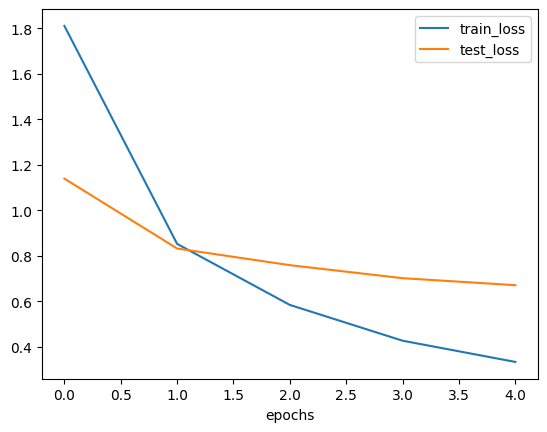

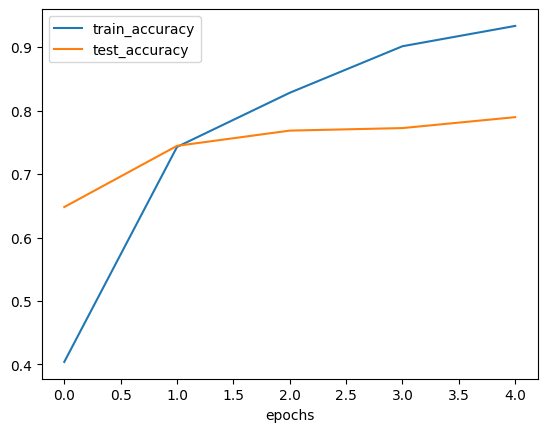

In [ ]:
# Test our model
plot_loss_curve(resnet_hist)

## Let's make our model from efficient model

In [ ]:
# 1. craet model
efficientnet_model = create_model(model_url=efficietnet_b0_url,
                            class_nums = train_data_10_precent.num_classes)

# 2. compile model
efficientnet_model.compile(loss='categorical_crossentropy',
                     optimizer=Adam(),
                     metrics=['accuracy'])

In [ ]:
# 3. fit our model
efficientnet_hist = efficientnet_model.fit(train_data_10_precent,
                               epochs = 5,
                               steps_per_epoch = len(train_data_10_precent),
                               validation_data = test_data_10_precent,
                               validation_steps = len(test_data_10_precent),
                               callbacks=[create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                      exp_name = 'efficietnet_b0')])

Saving TensorBoard in tensorflow_hub/efficietnet_b0/20230913-010452
Epoch 1/5
24/24 [==============================] - 23s 543ms/step - loss: 1.8836 - accuracy: 0.4120 - val_loss: 1.3453 - val_accuracy: 0.7000
Epoch 2/5
24/24 [==============================] - 10s 426ms/step - loss: 1.0872 - accuracy: 0.7760 - val_loss: 0.8915 - val_accuracy: 0.8072
Epoch 3/5
24/24 [==============================] - 11s 461ms/step - loss: 0.7688 - accuracy: 0.8320 - val_loss: 0.7163 - val_accuracy: 0.8292
Epoch 4/5
24/24 [==============================] - 13s 537ms/step - loss: 0.6156 - accuracy: 0.8587 - val_loss: 0.6231 - val_accuracy: 0.8440
Epoch 5/5
24/24 [==============================] - 10s 441ms/step - loss: 0.5196 - accuracy: 0.8800 - val_loss: 0.5690 - val_accuracy: 0.8544


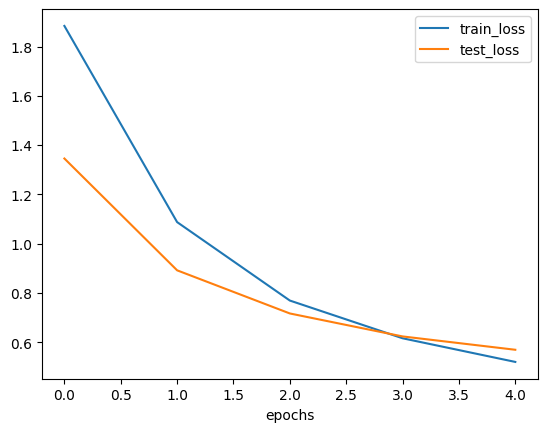

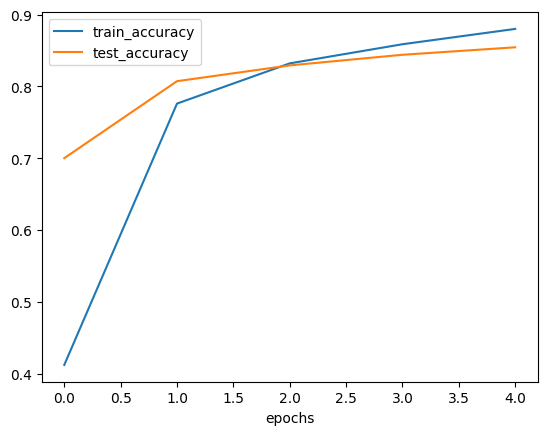

In [ ]:
# visualize our model
plot_loss_curve(efficientnet_hist)

## Let's compare our models

In [ ]:
# model resnet evaluate
resnet_model.evaluate(test_data_10_precent)

79/79 [==============================] - 8s 101ms/step - loss: 0.6704 - accuracy: 0.7896


[0.6704200506210327, 0.7896000146865845]

In [ ]:
# model efficientnet evaluate
efficientnet_model.evaluate(test_data_10_precent)

79/79 [==============================] - 8s 102ms/step - loss: 0.5690 - accuracy: 0.8544


[0.5689744353294373, 0.8543999791145325]

## Let's check on Our models on TensorBorad
Which is Better ?!!!

In [15]:
!tensorboard dev upload --logdir /content/tensorflow_hub \
  --name "EfficientNetB0 vs. ResNet50V2" \
  --description "Comparing two different TF Hub feature extraction models architectures using 10% of training images" \
  --one_shot

2023-09-13 01:42:20.962020: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/tensorflow_hub

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   YXCQ-WLVB



New experiment created. View your TensorBoard at: https://tensorboard.de

In [16]:
# show list of all tesnorboard exprements
!tensorboard dev list

2023-09-13 01:43:47.696086: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
https://tensorboard.dev/experiment/eRdVkJ5KRtGo7VaP2COORQ/
	Name                 EfficientNetB0 vs. ResNet50V2
	Description          Comparing two different TF Hub feature extraction models architectures using 10% of training images
	Id                   eRdVkJ5KRtGo7VaP2COORQ
	Created              2023-09-13 01:42:58 (52 seconds ago)
	Updated              2023-09-13 01:43:02 (48 seconds ago)
	Runs                 4
	Tags                 5
	Scalars              60
	Tensor bytes         0
	Binary object bytes  6241030
Total: 1 experiment(s)
